Main notebook where some more EDA is done and the classification models are developed and optimized.

In [43]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

## Data Clean up and EDA

In [2]:
# Opens pickle file into a dataframe.  This is the data from murderdata.org
file_path = 'murder_data.pickle'
df = pd.read_pickle(file_path)

In [3]:
# Opens pickle file into a dataframe.  This data is from the census and includes
# demographic information about each state (average income, education attainment)
# diversity, etc.
file_path = 'state_demo.pickle'
state_demo = pd.read_pickle(file_path)

In [4]:
# Fixes some misspellings and discrepancy of capitalization in the dataframes
state_demo = state_demo.replace(['District Of Columbia'],['District of Columbia'])
df = df.replace(['Rhodes Island'],['Rhode Island'])

# Merges the two dataframes
df_full = df.merge(state_demo, how='left', left_on = 'State', right_on = 'State')

# Converts the unknown label for age from 999 to 101
df_full['VicAge_mod'] = df_full['VicAge'].replace(999,101)

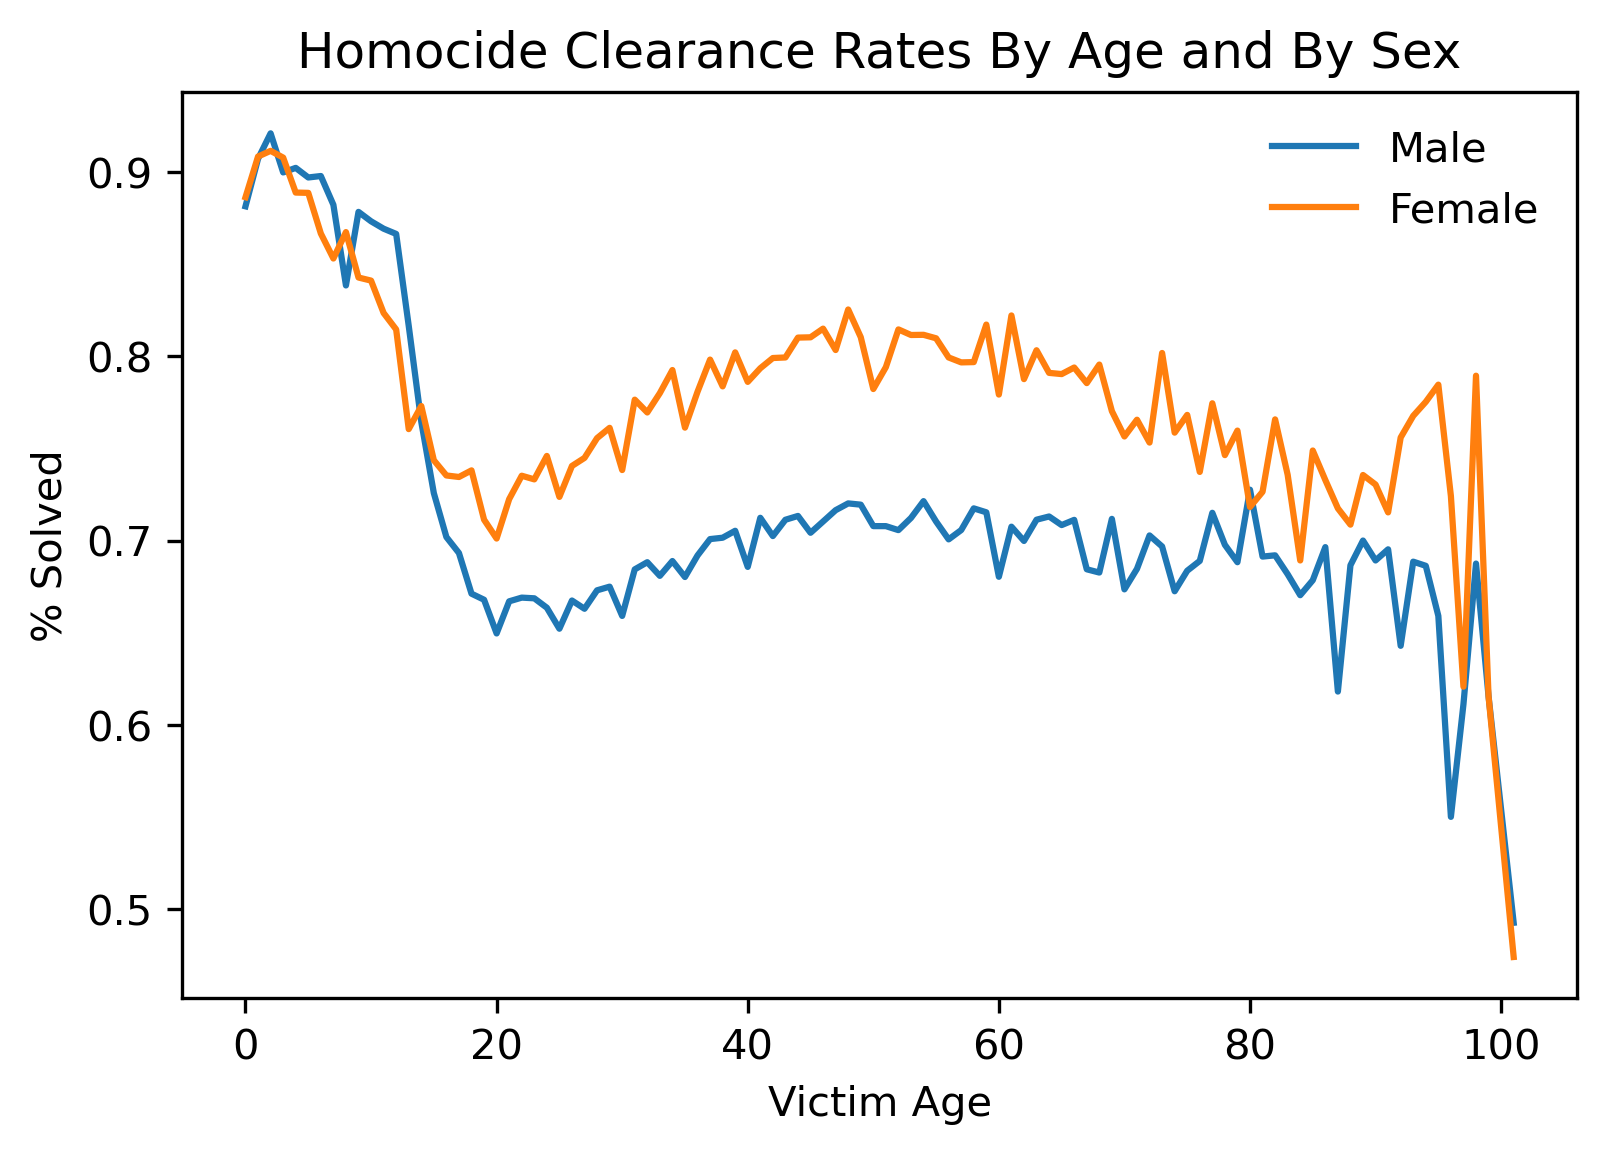

In [5]:
# Plots the solve percentages for males and for females by age
fig, ax = plt.subplots(1, 1,dpi = 300)

sns.lineplot(data = df_full[df_full['VicSex']=='Male'].groupby(['VicAge_mod'])['Solved_nums'].mean().sort_values());
sns.lineplot(data = df_full[df_full['VicSex']=='Female'].groupby(['VicAge_mod'])['Solved_nums'].mean().sort_values());

ax.set_ylabel('% Solved');
ax.set_xlabel('Victim Age');
ax.set_title('Homocide Clearance Rates By Age and By Sex');
ax.legend(['Male', 'Female'], framealpha=0);

In [6]:
# Gets solve rates by race
df.groupby(['VicRace'])['Solved_nums'].mean()

VicRace
American Indian or Alaskan Native      0.798239
Asian                                  0.707937
Black                                  0.669259
Native Hawaiian or Pacific Islander    0.892857
Unknown                                0.556431
White                                  0.743074
Name: Solved_nums, dtype: float64

In [14]:
# Gets solve rates by states.  Shows the top 5 worst states
df.groupby(['State'])['Solved_nums'].mean().sort_values()[:5]

State
District of Columbia    0.377010
New York                0.547647
Maryland                0.594758
Illinois                0.621342
California              0.636948
Name: Solved_nums, dtype: float64

## Modelling and Optimizing Models

In [61]:
# Get column names for df_full
df_full.columns

Index(['ID', 'CNTYFIPS', 'Ori', 'State', 'Agency', 'Agentype', 'Source',
       'Solved', 'Year', 'Month', 'Incident', 'ActionType', 'Homicide',
       'Situation', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic', 'OffAge',
       'OffSex', 'OffRace', 'OffEthnic', 'Weapon', 'Relationship',
       'Circumstance', 'Subcircum', 'VicCount', 'OffCount', 'FileDate',
       'fstate', 'MSA', 'VicAge_mod', 'Solved_nums', 'WAGP', 'SCHL', 'Black',
       'White', 'Native American'],
      dtype='object')

In [50]:
# Set X and y values for the data set.  Splits the data into test, train and val sets
X = df_full[['State', 'VicAge_mod', 'VicSex', 'VicRace', 'VicEthnic', 'Weapon', 'Year', 'Circumstance', 
        'Agentype', 'Black', 'White', 'Native American', 'SCHL']]

X = pd.get_dummies(X).drop(['VicEthnic_Unknown or not reported', 'VicRace_Unknown', 'Circumstance_Other',
                           'Agentype_Special police', 'Weapon_Other or type unknown', 'State_Alabama', 
                           'VicSex_Unknown'], axis=1)

y = df_full['Solved_nums']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state = 9)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state = 3)

In [51]:
# Scales the data
std = StandardScaler()
std.fit(X_train)
X_std = std.transform(X_train)
X_std_test = std.transform(X_test)
X_std_val = std.transform(X_val)

In [9]:
# Looks at class distribution to see if there is class imbalance
target_count = df['Solved_nums'].value_counts()
print(f'Class 0 (unsolved): {target_count[0]}')
print(f'Class 1 (solved): {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[1] / sum(target_count), 4)*100}')

Class 0 (unsolved): 226538
Class 1 (solved): 544487
Proportion: 0.42 : 1
Percentage of Majority Class: 70.62


In [52]:
# Since there seems to be some class imbalance, oversampled unsolved cases
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_std,y_train)

#Look at the counts for both classes to make sure oversampling worked
from collections import Counter
Counter(y_resampled)

Counter({1: 326728, 0: 326728})

In [138]:
# Using Adasyn to fix imbalance. Worried about overfitting, so did not
# end up using in final models
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X_train,y_train)
logistic_ada = LogisticRegression(solver='liblinear')
logistic_ada.fit(X_adasyn, y_adasyn);
print('Train:', logistic_ada.score(X_adasyn, y_adasyn))
print('Test:', logistic_ada.score(X_test, y_test))

Train: 0.8229187541973709
Test: 0.7746635971596252


In [137]:
import xgboost as xgb
gbm = xgb.XGBClassifier( 
                        n_estimators=100,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

#accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)) 
y_preds = gbm.predict(X_test)

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.66      0.55      0.60     45093
           1       0.83      0.89      0.85    109112

    accuracy                           0.79    154205
   macro avg       0.75      0.72      0.73    154205
weighted avg       0.78      0.79      0.78    154205



In [53]:
# Logistic regression model and it's classification report
logistic = LogisticRegression(solver='liblinear')
logistic.fit(X_resampled, y_resampled);
y_pred = logistic.predict(X_std_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.79      0.65     45093
           1       0.90      0.74      0.81    109112

    accuracy                           0.75    154205
   macro avg       0.72      0.76      0.73    154205
weighted avg       0.80      0.75      0.76    154205



In [58]:
# KNN model and it's classification report.  Took too long to run so did not end up
# using this
knn = KNeighborsClassifier(10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.57      0.58     45093
           1       0.83      0.84      0.83    109112

    accuracy                           0.76    154205
   macro avg       0.71      0.71      0.71    154205
weighted avg       0.76      0.76      0.76    154205



In [54]:
# Naive Bayes model and it's classification report
nb = GaussianNB()
nb.fit(X_resampled, y_resampled);
y_pred = nb.predict(X_std_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.34      0.94      0.50     45093
           1       0.90      0.24      0.38    109112

    accuracy                           0.44    154205
   macro avg       0.62      0.59      0.44    154205
weighted avg       0.74      0.44      0.41    154205



In [ ]:
# Took to long to run, so ended up not trying the support vector classifier model
svc = SVC()
svc.fit(X_resampled, y_resampled);
y_pred = svc.predict(X_std_test)
print(classification_report(y_test, y_pred))

In [55]:
# Decision Tree Classifier model and it's classification report
dtc = DecisionTreeClassifier()
dtc.fit(X_resampled, y_resampled);
y_pred = dtc.predict(X_std_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.61      0.58     45093
           1       0.83      0.80      0.81    109112

    accuracy                           0.74    154205
   macro avg       0.69      0.71      0.70    154205
weighted avg       0.75      0.74      0.75    154205



In [56]:
# Random Forest Classifier model and it's classification report
rfc = RandomForestClassifier()
rfc.fit(X_resampled, y_resampled);
y_pred = rfc.predict(X_std_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.65      0.63     45093
           1       0.85      0.82      0.84    109112

    accuracy                           0.77    154205
   macro avg       0.73      0.74      0.73    154205
weighted avg       0.78      0.77      0.77    154205



In [45]:
# XGB model and it's classification report
gbm = xgb.XGBClassifier( 
                        n_estimators=100,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_resampled, y_resampled),(X_std_val,y_val)]
gbm.fit(X_resampled, y_resampled, 
        eval_set=eval_set,
        eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
        early_stopping_rounds=50,
        verbose=False)
y_pred = gbm.predict(X_std_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.63      0.62     45093
           1       0.85      0.83      0.84    109112

    accuracy                           0.77    154205
   macro avg       0.73      0.73      0.73    154205
weighted avg       0.78      0.77      0.77    154205



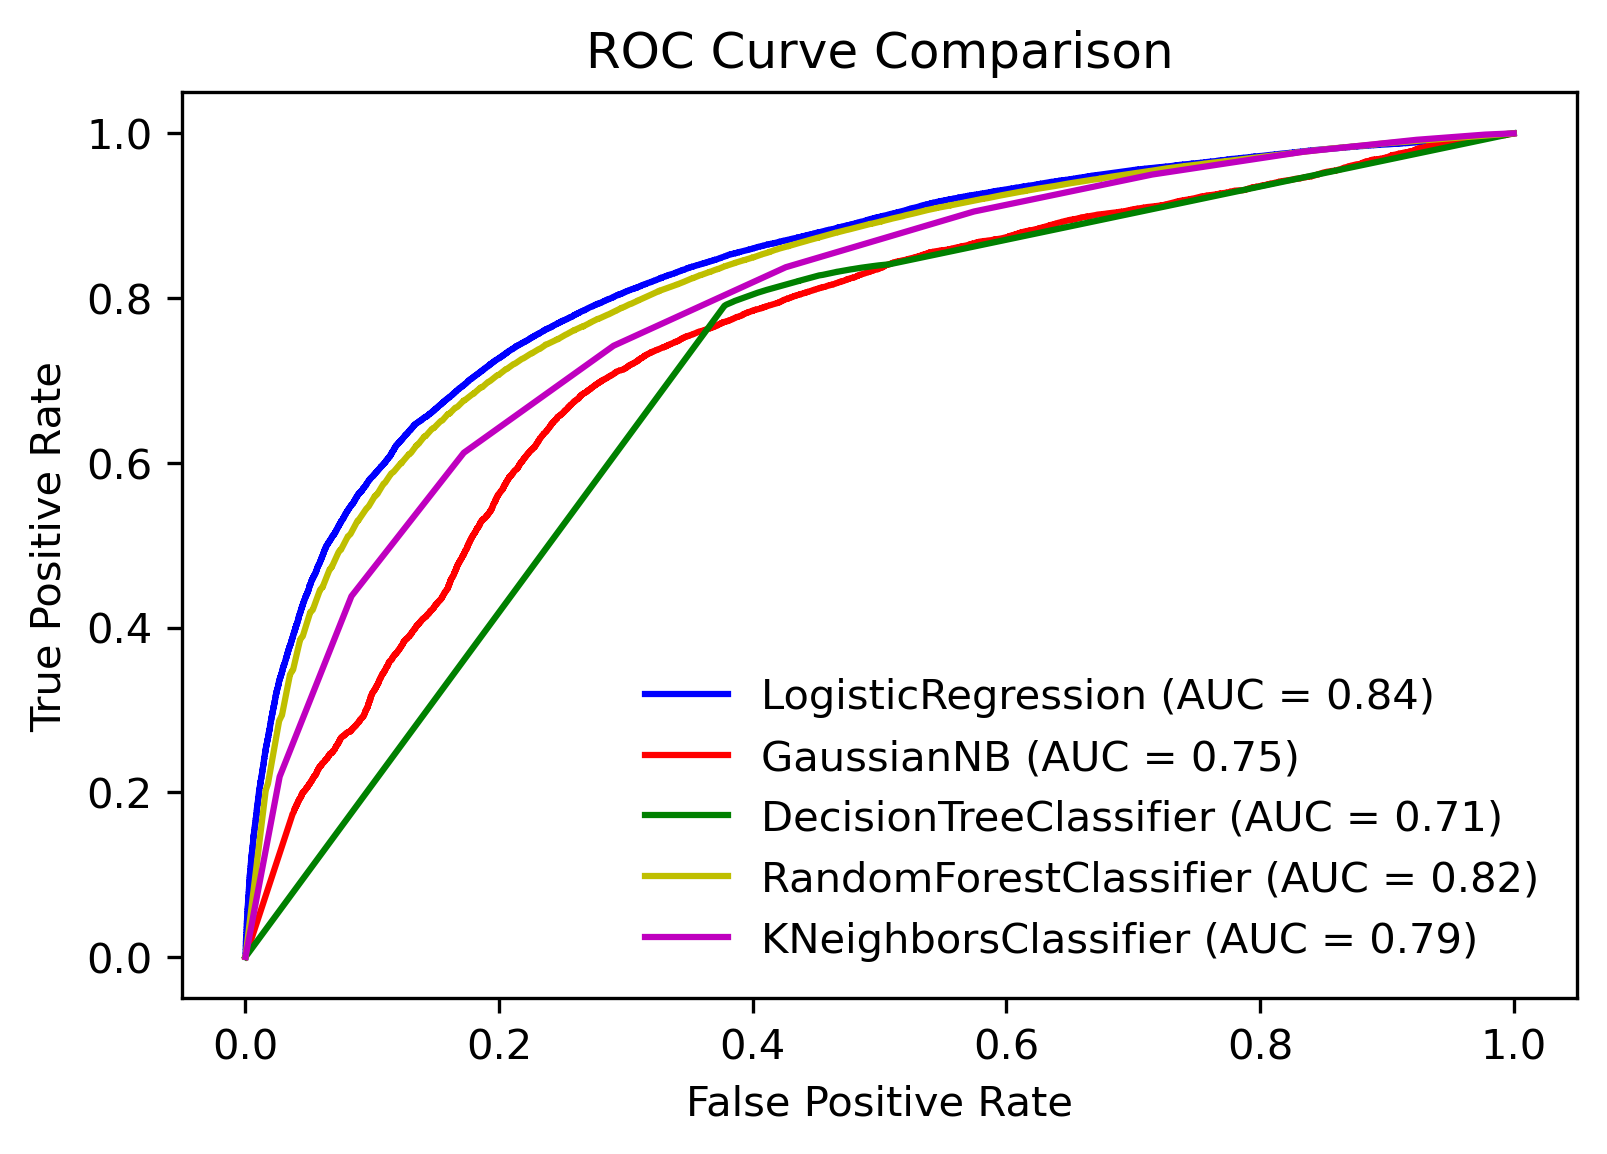

In [59]:
#Plots the ROC curves for the different models
fig, ax = plt.subplots(1, 1,dpi = 300);

plot_roc_curve(logistic, X_std_test, y_test, ax = ax, color = 'b');
plot_roc_curve(nb, X_std_test, y_test, ax=ax, color = 'r');
plot_roc_curve(dtc, X_std_test, y_test, ax=ax, color = 'g');
plot_roc_curve(rfc, X_std_test, y_test, ax=ax, color = 'y');
plot_roc_curve(knn, X_test, y_test, ax=ax, color = 'm');

ax.set_title('ROC Curve Comparison');
ax.legend(framealpha=0);
#plt.savefig('ROC', transparent=True);

Based on the previous classification reports and ROC plots, we decided to go with logistic regression.  It's performance was pretty comparable to the Random Forest Classifier, but we are moving forward with logistic regression because it is a bit more interpretable.

In [46]:
# Check model with the validation set.  Looks pretty good so moving forward
print('Validate:', logistic.score(X_std_val, y_val))
print('Test:', logistic.score(X_std_test, y_test))

Validate: 0.7533737557147953
Test: 0.7522389027593139


In [40]:
# Logistic regression variable names and coefficients
list(zip(X_train.columns, (logistic.coef_).reshape(126)))

[('VicAge_mod', -0.10474252545176671),
 ('Year', 0.08679302234038327),
 ('Black', 0.05860737336077524),
 ('White', 0.1136889820588356),
 ('Native American', 0.016586901000432967),
 ('SCHL', -0.07318748446042563),
 ('State_Alabama', 0.06249195094370164),
 ('State_Alaska', 0.006633527782454497),
 ('State_Arizona', -0.0025092212418269593),
 ('State_Arkansas', 0.06285663593467684),
 ('State_California', -0.14369512281571012),
 ('State_Colorado', 0.041224449127224796),
 ('State_Connecticut', -0.007980824250535912),
 ('State_Delaware', 0.04241616766778471),
 ('State_District of Columbia', -0.04801019761915922),
 ('State_Florida', 0.002710092205666704),
 ('State_Georgia', -0.026215313628844154),
 ('State_Hawaii', 0.022444113915401905),
 ('State_Idaho', 0.0445959107656788),
 ('State_Illinois', -0.08994794586963138),
 ('State_Indiana', -0.02711619540753169),
 ('State_Iowa', 0.04352695804183914),
 ('State_Kansas', 0.05671652383906353),
 ('State_Kentucky', -0.012959234592811102),
 ('State_Louisia

In [173]:
# Picks out some features from the above list and plots it in a bar graph
d = {'Feature': ['Gang related violence', 'Narcotics related', 'Weapon: handgun', 'Asphyxiation', 
                 'Female', 'Male', 'Black', 'White', 
                 'Asian', 'Hispanic', 'Florida', 'Delaware'],
     'Values':[-0.0603, -0.0907, -0.0508, 0.00538, 
         0.086,  -0.084, -0.079, 0.0812, 
         0.0063, -0.0833, -0.0119, 0.0398]}
df_features =  pd.DataFrame(data=d)
df_features = df_features.sort_values(by = 'Values')

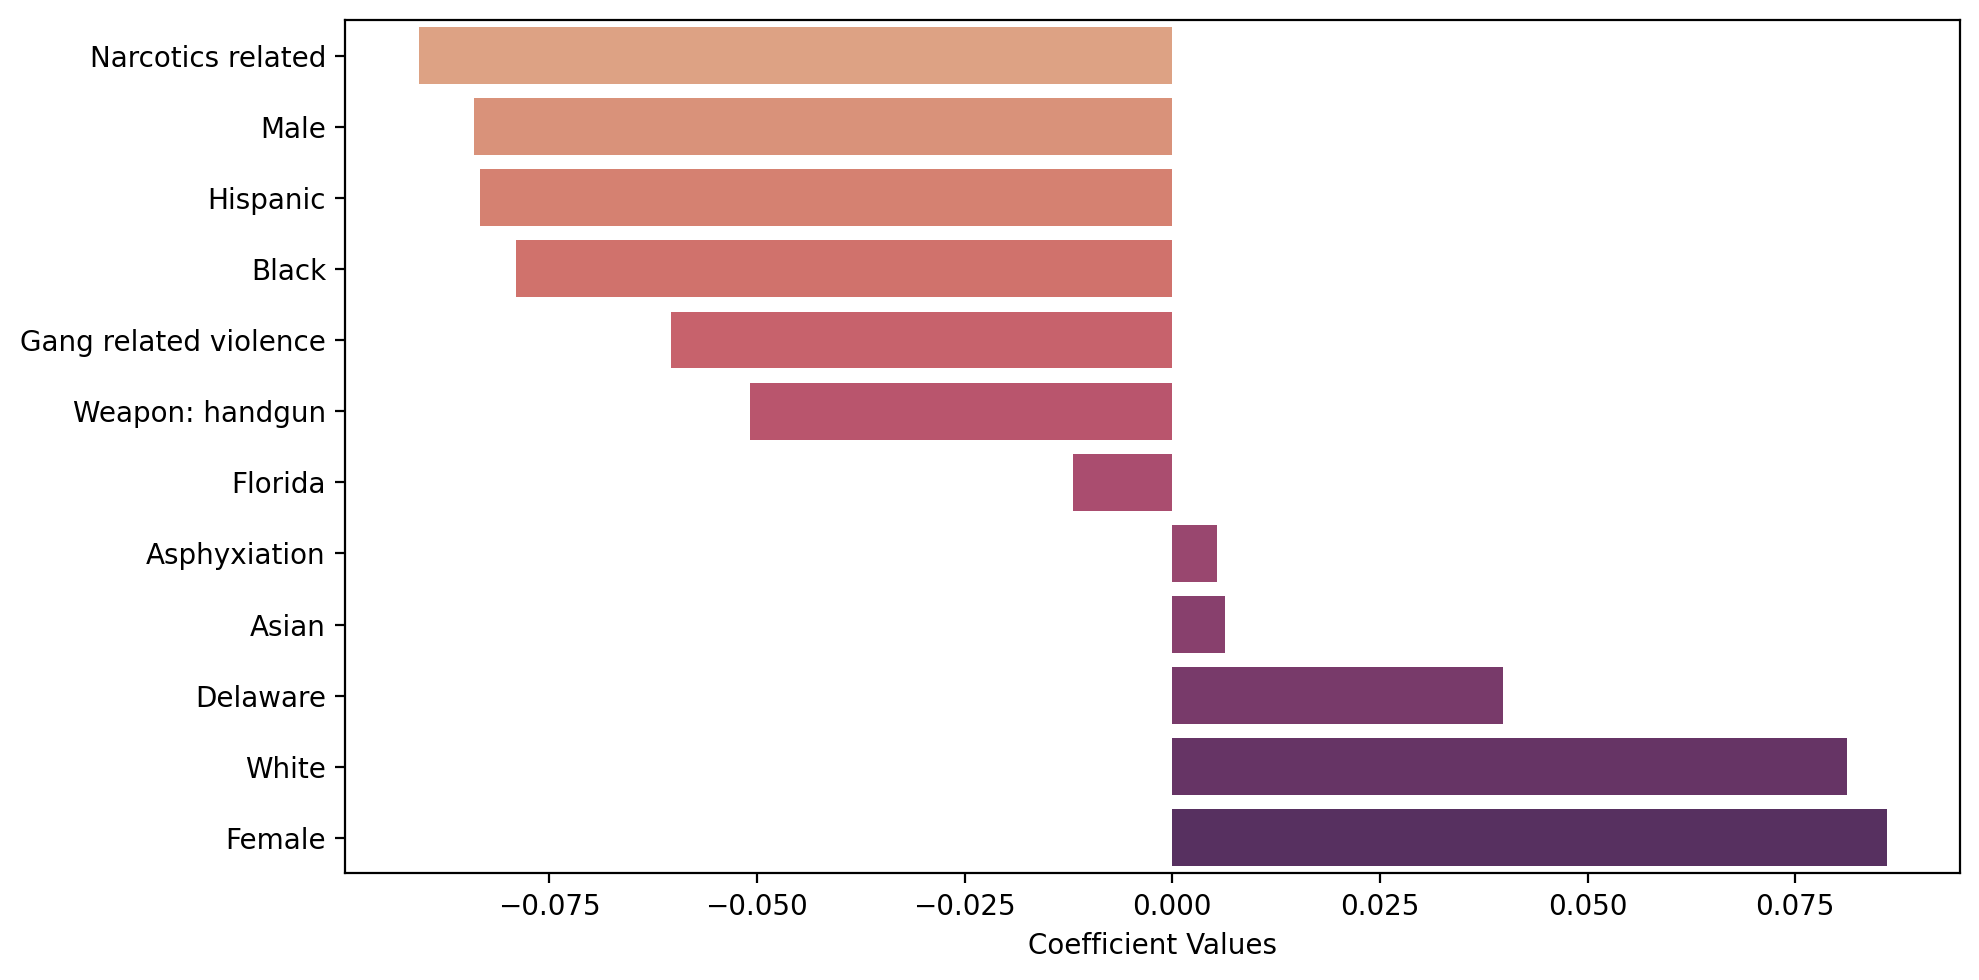

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(10,5), dpi = 200);

sns.barplot(data = df_features, y = 'Feature', x = 'Values', orient = 'h', palette = 'flare');
ax.set_ylabel("");
ax.set_xlabel('Coefficient Values');
plt.tight_layout();
#plt.savefig('features', transparent=True);